'''
最小二乘法拟合函数曲线f(x)
1、拟合多项式为：y = a0 + a1*x + a2*x^2 + ... + ak*x^k
2、求每个点到曲线的距离之和：Loss = ∑(yi - (a0 + a1*x + a2*x^2 + ... + ak*x^k))^2
3、最优化Loss函数，即求Loss对a0,a1,...ak的偏导数为0
    3.1、数学解法——求解线性方程组：
        整理最优化的偏导数矩阵为：X：含有xi的系数矩阵，A：含有ai的系数矩阵，Y：含有yi的系数矩阵
        求解：XA=Y中的A矩阵
    3.2、迭代解法——梯度下降法：
        计算每个系数矩阵A[k]的梯度，并迭代更新A[k]的梯度
        A[k] = A[k] - (learn_rate * gradient)
'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
'''高斯列主消元算法'''
# 得到增广矩阵
def get_augmented_matrix(matrix, b):
    row, col = np.shape(matrix)
    matrix = np.insert(matrix, col, values=b, axis=1)
    return matrix
# 取出增广矩阵的系数矩阵（第一列到倒数第二列）
def get_matrix(a_matrix):
    return a_matrix[:, :a_matrix.shape[1] - 1]
# 选列主元，在第k行后的矩阵里，找出最大值和其对应的行号和列号
def get_pos_j_max(matrix, k):
    max_v = np.max(matrix[k:, :])
    pos = np.argwhere(matrix == max_v)
    i, _ = pos[0]
    return i, max_v
# 矩阵的第k行后，行交换
def exchange_row(matrix, r1, r2, k):
    matrix[[r1, r2], k:] = matrix[[r2, r1], k:]
    return matrix
# 消元计算(初等变化)
def elimination(matrix, k):
    row, col = np.shape(matrix)
    for i in range(k + 1, row):
        m_ik = matrix[i][k] / matrix[k][k]
        matrix[i] = -m_ik * matrix[k] + matrix[i]
    return matrix
# 回代求解
def backToSolve(a_matrix):
    matrix = a_matrix[:, :a_matrix.shape[1] - 1]  # 得到系数矩阵
    b_matrix = a_matrix[:, -1]  # 得到值矩阵
    row, col = np.shape(matrix)
    x = [None] * col  # 待求解空间X
    # 先计算上三角矩阵对应的最后一个分量
    x[-1] = b_matrix[col - 1] / matrix[col - 1][col - 1]
    # 从倒数第二行开始回代x分量
    for _ in range(col - 1, 0, -1):
        i = _ - 1
        sij = 0
        xidx = len(x) - 1
        for j in range(col - 1, i, -1):
            sij += matrix[i][j] * x[xidx]
            xidx -= 1
        x[xidx] = (b_matrix[i] - sij) / matrix[i][i]
    return x

In [3]:
# 求解非齐次线性方程组：ax=b
def solve_NLQ(a, b):
    a_matrix = get_augmented_matrix(a, b)
    for k in range(len(a_matrix) - 1):
        # 选列主元
        max_i, max_v = get_pos_j_max(get_matrix(a_matrix), k=k)
        # 如果A[ik][k]=0，则矩阵奇异退出
        if a_matrix[max_i][k] == 0:
            print('矩阵A奇异')
            return None, []
        if max_i != k:
            a_matrix = exchange_row(a_matrix, k, max_i, k=k)
        # 消元计算
        a_matrix = elimination(a_matrix, k=k)
    # 回代求解
    X = backToSolve(a_matrix)
    return a_matrix, X

In [4]:
'''
最小二乘法多项式拟合曲线
'''
# 生成带有噪点的待拟合的数据集合
def init_fx_data():
    # 待拟合曲线f(x) = sin2x * [(x^2 - 1)^3 + 0.5]
    xs = np.arange(-1, 1, 0.01)  # 200个点
    ys = [((x ** 2 - 1) ** 3 + 0.5) * np.sin(x * 2) for x in xs]
    ys1 = []
    for i in range(len(ys)):
        z = np.random.randint(low=-10, high=10) / 100  # 加入噪点
        ys1.append(ys[i] + z)
    return xs, ys1
# 计算最小二乘法当前的误差
def last_square_current_loss(xs, ys, A):
    error = 0.0
    for i in range(len(xs)):
        y1 = 0.0
        for k in range(len(A)):
            y1 += A[k] * xs[i] ** k
        error += (ys[i] - y1) ** 2
    return error

In [59]:
# 迭代解法：最小二乘法+梯度下降法
def last_square_fit_curve_Gradient(xs, ys, order, iternum=1000, learn_rate=0.001):
    A = [0.0] * (order + 1)
    for r in range(iternum + 1):
        for k in range(len(A)):
            gradient = 0.0
            for i in range(len(xs)):
                y1 = 0.0
                for j in range(len(A)):
                    y1 += A[j] * xs[i]**j
                gradient += -2 * (ys[i] - y1) * xs[i]**k  # 计算A[k]的梯度
            A[k] = A[k] - (learn_rate * gradient)  # 更新A[k]的梯度
        # 检查误差变化
        if r % 100 == 0:
            error = last_square_current_loss(xs=xs, ys=ys, A=A)
            print('最小二乘法+梯度下降法：第{}次迭代，误差下降为：{}'.format(r, error))
    return A
# 数学解法：最小二乘法+求解线性方程组
def last_square_fit_curve_Gauss(xs, ys, order):
    X, Y = [], []
    # 求解偏导数矩阵里，含有xi的系数矩阵X
    for i in range(0, order + 1):
        X_line = []
        for j in range(0, order + 1):
            sum_xi = 0.0
            for xi in xs:
                sum_xi += xi ** (j + i)
            X_line.append(sum_xi)
        X.append(X_line)
    # 求解偏导数矩阵里，含有yi的系数矩阵Y
    for i in range(0, order + 1):
        Y_line = 0.0
        for j in range(0, order + 1):
            sum_xi_yi = 0.0
            for k in range(len(xs)):
                sum_xi_yi += (xs[k] ** i * ys[k])
            Y_line = sum_xi_yi
        Y.append(Y_line)
    a_matrix, A = solve_NLQ(np.array(X), Y)  # 高斯消元：求解XA=Y的A
    # A = np.linalg.solve(np.array(X), np.array(Y))  # numpy API 求解XA=Y的A
    error = last_square_current_loss(xs=xs, ys=ys, A=A)
    
    print(f'拟合的多项式函数系数---a0-a{len(Y)-1}---为:{Y}')
    print(f'最小二乘法+求解线性方程组，误差下降为：{error}')
    return A
# 可视化多项式曲线拟合结果
def draw_fit_curve(xs, ys, A, order):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fit_xs, fit_ys = np.arange(min(xs) * 0.8, max(xs) * 0.8, 0.01), []
    for i in range(0, len(fit_xs)):
        y = 0.0
        for k in range(0, order + 1):
            y += (A[k] * fit_xs[i] ** k)
        fit_ys.append(y)
    ax.plot(fit_xs, fit_ys, color='g', linestyle='-', marker='', label='多项式拟合曲线')
    ax.plot(xs, ys, color='m', linestyle='', marker='.', label='曲线真实数据')
    plt.title(label='最小二乘法拟合多项式N={}的函数曲线f(x)'.format(order))
    plt.legend()
    plt.show()

拟合的多项式函数系数---a0-a10---为:[-1.734648713412768, 26.58807024157549, -0.878421713412764, 19.213676362308238, -0.6509711955127766, 14.190117593615396, -0.5770547608072976, 11.043562096538533, -0.5401025654603795, 8.96539475404007, -0.5145829196216161]
最小二乘法+求解线性方程组，误差下降为：0.6871528112386605


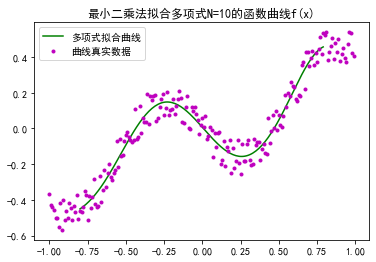

In [61]:
if __name__ == '__main__':
    order =10 # 拟合的多项式项数
    xs, ys = init_fx_data()  # 曲线数据
    # 数学解法：最小二乘法+求解线性方程组
    A = last_square_fit_curve_Gauss(xs=xs, ys=ys, order=order)
    # 迭代解法：最小二乘法+梯度下降
#     A = last_square_fit_curve_Gradient(xs=xs, ys=ys, order=order, iternum=1000, learn_rate=0.001)
    draw_fit_curve(xs=xs, ys=ys, A=A, order=order)  # 可视化多项式曲线拟合结果
